# **Business Understanding**

> This project is a self-project that can be used by the ChatGPT product team to understand the sentiment of Twitter users towards ChatGPT in order to assess user satisfaction and make improvements accordingly.

# **Data Understanding**

## Import Necessary Library and Modules

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import json, tweepy, requests, re, string, datetime, nltk, googletrans, gensim, tqdm
import seaborn as sns


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from requests_oauthlib import OAuth1

from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.corpus import stopwords
from nltk.probability import FreqDist

from textblob import TextBlob
from googletrans import Translator

from urllib.request import urlopen
from bs4 import BeautifulSoup
from tabulate import tabulate

from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

from numpy import array

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FITRI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\FITRI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\FITRI\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\FITRI\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Collect the Data

> Authentication to retrieve data from Twitter. Tokens can be created through https://developer.twitter.com/.


In [ ]:
with open("token.json")as f:
  tokens = json.load(f)

bearer_token = tokens['bearer_token']
api_key = tokens['api_key']
api_key_secret = tokens['api_key_secret']
access_token = tokens['access_token']
access_token_secret = tokens['access_token_secret']

> At this step, I retrieved 3000 English tweets containing the word 'chatgpt' from May 28th, from 9 PM to 12 AM.

In [ ]:
def tweet_scraper(query):
  api = tweepy.Client(bearer_token=bearer_token, wait_on_rate_limit=True)
  response = tweepy.Paginator(api.search_recent_tweets ,
                            query = query,
                            start_time = "2023-05-28T21:00:00Z",
                            end_time = "2023-05-28T23:59:59Z",
                            tweet_fields=['created_at', 'public_metrics'],
                            user_fields = ["username"],
                            max_results= 100,
                            expansions='author_id'
                            ).flatten(limit=3000)
  tweets = []
  for tweet in response:
    author =  api.get_user(id=tweet.author_id).data
    parsed_tweet = {}
    parsed_tweet['username'] = author.username
    parsed_tweet['location'] = author.location
    parsed_tweet['text'] = tweet.text.strip()
    parsed_tweet['created_at'] = tweet.created_at
    parsed_tweet['rt_count'] = tweet.public_metrics["retweet_count"]
    parsed_tweet['like_count'] = tweet.public_metrics["like_count"]
    parsed_tweet['impression_count'] = tweet.public_metrics['impression_count']
    parsed_tweet['url'] = 'https://twitter.com/twitter/status/' + str(tweet.id)
    tweets.append(parsed_tweet)

  return tweets

In [ ]:
query = "chatgpt -is:retweet lang:en"
df_tweets = pd.DataFrame(tweet_scraper(query))
df_tweets = df_tweets.drop_duplicates("text", keep='first')

Rate limit exceeded. Sleeping for 61 seconds.
Rate limit exceeded. Sleeping for 826 seconds.
Rate limit exceeded. Sleeping for 836 seconds.
Rate limit exceeded. Sleeping for 839 seconds.
Rate limit exceeded. Sleeping for 840 seconds.
Rate limit exceeded. Sleeping for 842 seconds.
Rate limit exceeded. Sleeping for 840 seconds.


> Here is the data

In [ ]:
df_tweets.head()

,username,location,text,created_at,rt_count,like_count,impression_count,url
0,bethelome,None,#Breaking: How Does ChatGPT Work? What Is an A...,2023-05-28 23:59:58+00:00,0,0,24,https://twitter.com/twitter/status/16629720109...
1,timbocop,None,"@CCguerilla In a summative assessment context,...",2023-05-28 23:59:43+00:00,0,1,77,https://twitter.com/twitter/status/16629719471...
2,SystematicAlpha,None,$MSFT will eat the world and be the most valua...,2023-05-28 23:59:42+00:00,0,0,27,https://twitter.com/twitter/status/16629719413...
3,xPaterax,None,Using ChatGPT?\n\nHave you met BetterDAN yet? ...,2023-05-28 23:59:30+00:00,0,0,41,https://twitter.com/twitter/status/16629718935...
4,alyceralphlplq,None,@MartianCorazon #AkiNetwork #GPTMiner Exciting...,2023-05-28 23:59:24+00:00,0,0,2,https://twitter.com/twitter/status/16629718696...


In [ ]:
df_tweets.shape

(1963, 8)

In [ ]:
df_twts = df_tweets.copy()

# **Data Preprocessing**

Before conducting the analysis, the data is preprocessed to ensure more accurate results. The preprocessing is done through several steps, which include:
- Removing numbers, punctuation marks, capital letters, URLs, and mentions
- Removing commonly used words from sentences (stopwords).
- Stemming or lemmatizing the words to their root form.

In [ ]:
def check_values(df):
    data = []
    for col in df.columns:
        data.append([col, \
                  df[col].dtype, \
                  df[col].isna().sum(), \
                  round(100*(df[col].isna().sum()/len(df)), 2), \
                  df[col].nunique(), \
                  df[col].unique()
                  ])
    
    return pd.DataFrame(columns=['kolom', 'dataType', 'null', 'nullPercentage', 'unique', 'values'], data=data)

In [ ]:
check_values(df_twts)

,kolom,dataType,null,nullPercentage,unique,values
0,username,object,0,0.0,1325,"[bethelome, timbocop, SystematicAlpha, xPatera..."
1,location,object,1963,100.0,0,[None]
2,text,object,0,0.0,1963,[#Breaking: How Does ChatGPT Work? What Is an ...
3,created_at,"datetime64[ns, UTC]",0,0.0,1734,"[2023-05-28 23:59:58+00:00, 2023-05-28 23:59:4..."
4,rt_count,int64,0,0.0,20,"[0, 1, 2, 7, 3, 5, 26, 14, 322, 130, 8, 51, 4,..."
5,like_count,int64,0,0.0,54,"[0, 1, 3, 4, 13, 2, 11, 10, 5, 7, 8, 9, 20, 17..."
6,impression_count,int64,0,0.0,417,"[24, 77, 27, 41, 2, 40, 133, 5, 11, 4, 96, 325..."
7,url,object,0,0.0,1963,[https://twitter.com/twitter/status/1662972010...


In [ ]:
def casefolding(text):
  # lower case
  text = text.lower()

  # menghilangkan tag, tautan, dan angka
  text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^A-Za-z \t])|(\w+:\/\/\S+)|(\d+)", " ", text).split())

  # menghilangkan tanda baca
  text = text.translate(str.maketrans("","",string.punctuation))
  
  # Menghilangkan whitespaces
  text = text.strip()

  return text

In [ ]:
def remove_stopword(text):
    stop_words = stopwords.words('english')
    stop_words.extend(['like', 'use', 'using', 'use', 'used', 'make', 'made', 'could', 'would', 'get'])
    stop_words = set(stop_words)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [ ]:
ls = LancasterStemmer()
lem = WordNetLemmatizer()

def lexicon_normalization(text):
    words = word_tokenize(text) 
    
    # 1- Stemming
    words_stem = [ls.stem(w) for w in words]
    
    # 2- Lemmatization
    words_lem = [lem.lemmatize(w) for w in words_stem]
    return words_lem

In [ ]:
def tokenise(text):
    words = word_tokenize(text) 
    return words

In [ ]:
df_twts['clean'] = df_twts['text'].apply(casefolding)
df_twts.tail()

,username,location,text,created_at,rt_count,like_count,impression_count,url,clean
1972,thedebrieft,None,"""What Is an AI 'Black Box'?""\n\nGet the lowdow...",2023-05-28 21:00:04+00:00,0,0,64,https://twitter.com/twitter/status/16629267375...,what is an ai black box get the lowdown in our...
1973,crypaudio,None,ChatGPT creates Auburn football all-decade tea...,2023-05-28 21:00:03+00:00,0,1,13,https://twitter.com/twitter/status/16629267345...,chatgpt creates auburn football all decade tea...
1974,jj_devbot_,None,Noun: twenty\n\nA twenty is when you've got tw...,2023-05-28 21:00:02+00:00,0,2,4,https://twitter.com/twitter/status/16629267278...,noun twenty a twenty is when you ve got twenty...
1975,AqurusSolutions,None,ChatGPT isn't just for helping people with the...,2023-05-28 21:00:01+00:00,0,0,9,https://twitter.com/twitter/status/16629267233...,chatgpt isn t just for helping people with the...
1976,nTangledCloud,None,New Cooperative Cybersecurity Models Needed In...,2023-05-28 21:00:00+00:00,1,1,60,https://twitter.com/twitter/status/16629267208...,new cooperative cybersecurity models needed in...


In [ ]:
df_twts['clean'] = df_twts['clean'].apply(remove_stopword)
df_twts.tail()

,username,location,text,created_at,rt_count,like_count,impression_count,url,clean
1972,thedebrieft,None,"""What Is an AI 'Black Box'?""\n\nGet the lowdow...",2023-05-28 21:00:04+00:00,0,0,64,https://twitter.com/twitter/status/16629267375...,ai black box lowdown latest thread
1973,crypaudio,None,ChatGPT creates Auburn football all-decade tea...,2023-05-28 21:00:03+00:00,0,1,13,https://twitter.com/twitter/status/16629267345...,chatgpt creates auburn football decade team sp...
1974,jj_devbot_,None,Noun: twenty\n\nA twenty is when you've got tw...,2023-05-28 21:00:02+00:00,0,2,4,https://twitter.com/twitter/status/16629267278...,noun twenty twenty got twenty dollars pocket r...
1975,AqurusSolutions,None,ChatGPT isn't just for helping people with the...,2023-05-28 21:00:01+00:00,0,0,9,https://twitter.com/twitter/status/16629267233...,chatgpt helping people speeches see generative...
1976,nTangledCloud,None,New Cooperative Cybersecurity Models Needed In...,2023-05-28 21:00:00+00:00,1,1,60,https://twitter.com/twitter/status/16629267208...,new cooperative cybersecurity models needed er...


In [ ]:
df_twts['stem'] = df_twts['clean'].apply(lexicon_normalization)
df_twts.tail()

,username,location,text,created_at,rt_count,like_count,impression_count,url,clean,stem
1972,thedebrieft,None,"""What Is an AI 'Black Box'?""\n\nGet the lowdow...",2023-05-28 21:00:04+00:00,0,0,64,https://twitter.com/twitter/status/16629267375...,ai black box lowdown latest thread,"[ai, black, box, lowdown, latest, thread]"
1973,crypaudio,None,ChatGPT creates Auburn football all-decade tea...,2023-05-28 21:00:03+00:00,0,1,13,https://twitter.com/twitter/status/16629267345...,chatgpt creates auburn football decade team sp...,"[chatgpt, cre, auburn, footbal, decad, team, s..."
1974,jj_devbot_,None,Noun: twenty\n\nA twenty is when you've got tw...,2023-05-28 21:00:02+00:00,0,2,4,https://twitter.com/twitter/status/16629267278...,noun twenty twenty got twenty dollars pocket r...,"[noun, twenty, twenty, got, twenty, doll, pock..."
1975,AqurusSolutions,None,ChatGPT isn't just for helping people with the...,2023-05-28 21:00:01+00:00,0,0,9,https://twitter.com/twitter/status/16629267233...,chatgpt helping people speeches see generative...,"[chatgpt, help, peopl, speech, see, generative..."
1976,nTangledCloud,None,New Cooperative Cybersecurity Models Needed In...,2023-05-28 21:00:00+00:00,1,1,60,https://twitter.com/twitter/status/16629267208...,new cooperative cybersecurity models needed er...,"[new, coop, cybersec, model, nee, er, glob, fo..."


In [ ]:
df_twts['words'] = df_twts['clean'].apply(tokenise)
df_twts.tail()

,username,location,text,created_at,rt_count,like_count,impression_count,url,clean,stem,words
1972,thedebrieft,None,"""What Is an AI 'Black Box'?""\n\nGet the lowdow...",2023-05-28 21:00:04+00:00,0,0,64,https://twitter.com/twitter/status/16629267375...,ai black box lowdown latest thread,"[ai, black, box, lowdown, latest, thread]","[ai, black, box, lowdown, latest, thread]"
1973,crypaudio,None,ChatGPT creates Auburn football all-decade tea...,2023-05-28 21:00:03+00:00,0,1,13,https://twitter.com/twitter/status/16629267345...,chatgpt creates auburn football decade team sp...,"[chatgpt, cre, auburn, footbal, decad, team, s...","[chatgpt, creates, auburn, football, decade, t..."
1974,jj_devbot_,None,Noun: twenty\n\nA twenty is when you've got tw...,2023-05-28 21:00:02+00:00,0,2,4,https://twitter.com/twitter/status/16629267278...,noun twenty twenty got twenty dollars pocket r...,"[noun, twenty, twenty, got, twenty, doll, pock...","[noun, twenty, twenty, got, twenty, dollars, p..."
1975,AqurusSolutions,None,ChatGPT isn't just for helping people with the...,2023-05-28 21:00:01+00:00,0,0,9,https://twitter.com/twitter/status/16629267233...,chatgpt helping people speeches see generative...,"[chatgpt, help, peopl, speech, see, generative...","[chatgpt, helping, people, speeches, see, gene..."
1976,nTangledCloud,None,New Cooperative Cybersecurity Models Needed In...,2023-05-28 21:00:00+00:00,1,1,60,https://twitter.com/twitter/status/16629267208...,new cooperative cybersecurity models needed er...,"[new, coop, cybersec, model, nee, er, glob, fo...","[new, cooperative, cybersecurity, models, need..."


In [ ]:
df_twts = df_twts.drop_duplicates(subset=['clean']).reset_index(drop=True)
df_twts.tail()

,username,location,text,created_at,rt_count,like_count,impression_count,url,clean,stem,words
1657,thedebrieft,None,"""What Is an AI 'Black Box'?""\n\nGet the lowdow...",2023-05-28 21:00:04+00:00,0,0,64,https://twitter.com/twitter/status/16629267375...,ai black box lowdown latest thread,"[ai, black, box, lowdown, latest, thread]","[ai, black, box, lowdown, latest, thread]"
1658,crypaudio,None,ChatGPT creates Auburn football all-decade tea...,2023-05-28 21:00:03+00:00,0,1,13,https://twitter.com/twitter/status/16629267345...,chatgpt creates auburn football decade team sp...,"[chatgpt, cre, auburn, footbal, decad, team, s...","[chatgpt, creates, auburn, football, decade, t..."
1659,jj_devbot_,None,Noun: twenty\n\nA twenty is when you've got tw...,2023-05-28 21:00:02+00:00,0,2,4,https://twitter.com/twitter/status/16629267278...,noun twenty twenty got twenty dollars pocket r...,"[noun, twenty, twenty, got, twenty, doll, pock...","[noun, twenty, twenty, got, twenty, dollars, p..."
1660,AqurusSolutions,None,ChatGPT isn't just for helping people with the...,2023-05-28 21:00:01+00:00,0,0,9,https://twitter.com/twitter/status/16629267233...,chatgpt helping people speeches see generative...,"[chatgpt, help, peopl, speech, see, generative...","[chatgpt, helping, people, speeches, see, gene..."
1661,nTangledCloud,None,New Cooperative Cybersecurity Models Needed In...,2023-05-28 21:00:00+00:00,1,1,60,https://twitter.com/twitter/status/16629267208...,new cooperative cybersecurity models needed er...,"[new, coop, cybersec, model, nee, er, glob, fo...","[new, cooperative, cybersecurity, models, need..."


In [ ]:
df_twts = df_twts.drop(columns=['location']).reset_index(drop=True)
df_twts.tail()

,username,text,created_at,rt_count,like_count,impression_count,url,clean,stem,words
1657,thedebrieft,"""What Is an AI 'Black Box'?""\n\nGet the lowdow...",2023-05-28 21:00:04+00:00,0,0,64,https://twitter.com/twitter/status/16629267375...,ai black box lowdown latest thread,"[ai, black, box, lowdown, latest, thread]","[ai, black, box, lowdown, latest, thread]"
1658,crypaudio,ChatGPT creates Auburn football all-decade tea...,2023-05-28 21:00:03+00:00,0,1,13,https://twitter.com/twitter/status/16629267345...,chatgpt creates auburn football decade team sp...,"[chatgpt, cre, auburn, footbal, decad, team, s...","[chatgpt, creates, auburn, football, decade, t..."
1659,jj_devbot_,Noun: twenty\n\nA twenty is when you've got tw...,2023-05-28 21:00:02+00:00,0,2,4,https://twitter.com/twitter/status/16629267278...,noun twenty twenty got twenty dollars pocket r...,"[noun, twenty, twenty, got, twenty, doll, pock...","[noun, twenty, twenty, got, twenty, dollars, p..."
1660,AqurusSolutions,ChatGPT isn't just for helping people with the...,2023-05-28 21:00:01+00:00,0,0,9,https://twitter.com/twitter/status/16629267233...,chatgpt helping people speeches see generative...,"[chatgpt, help, peopl, speech, see, generative...","[chatgpt, helping, people, speeches, see, gene..."
1661,nTangledCloud,New Cooperative Cybersecurity Models Needed In...,2023-05-28 21:00:00+00:00,1,1,60,https://twitter.com/twitter/status/16629267208...,new cooperative cybersecurity models needed er...,"[new, coop, cybersec, model, nee, er, glob, fo...","[new, cooperative, cybersecurity, models, need..."


# **Data Processing**

## **Text Data Analysis**

Text data analysis is performed to gain a better understanding of the dataset's characteristics.

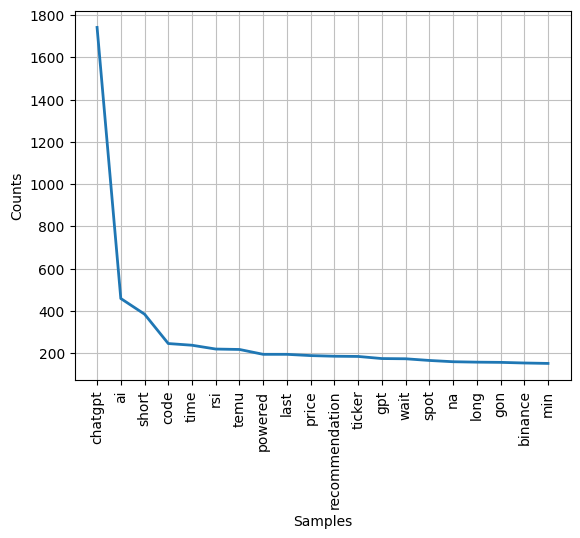

In [ ]:
tweets = [word for tweet in df_twts['words'] for word in tweet]
fqdist = FreqDist(tweets)
fqdist.plot(20,cumulative=False)
plt.show()

In [ ]:
most_common_word = fqdist.most_common(20)
pd.DataFrame(most_common_word, columns=['Word', 'freq']).to_csv("top_words_tweets.csv", index=False)

By examining the word distribution, it can be understood that "chatgpt" is at the top of the list because it is the key search term. The following words frequently appear: ai, short, code, time, rsi, temu, powered, last, price, reccommendation, ticker, gpt, wait, spot, na, long, gon, binance, min. A preliminary conclusion can be drawn that the overall tweets are about the AI called ChatGPT, related cryptocurrency, and its benefits.

In [ ]:
result = pd.Series(nltk.ngrams(tweets, 2)).value_counts()[:20]
print (result)

(recommendation, short)    185
(short, ticker)            185
(last, price)              185
(price, rsi)               185
(rsi, powered)             185
(powered, chatgpt)         185
(gon, na)                  157
(wait, short)              151
(long, wait)               151
(na, long)                 151
(min, last)                151
(interval, min)            151
(time, interval)           151
(spot, recommendation)     151
(binance, spot)            151
(lt, gt)                    99
(code, lt)                  99
(invitation, code)          97
(temu, invitation)          91
(shopping, app)             83
dtype: int64


In [ ]:
result_lst = result.index.tolist()
pd.DataFrame(result_lst, columns=['Word-1', 'Word-2']).to_csv("top_bg_tweets.csv", index=False)

> Here is the wordcloud from frequency distribution

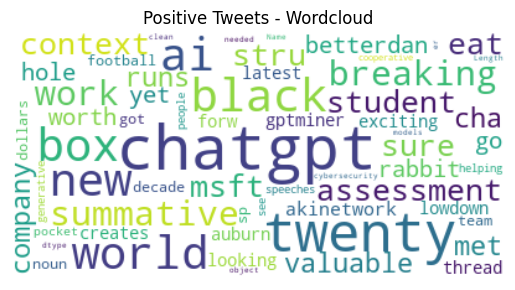

In [ ]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
 
tweets = df_twts['clean']
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(tweets))
plt.figure()
plt.title("Positive Tweets - Wordcloud")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## **Sentiment Analysis**

> Text data analysis is performed to gain a better understanding of the tweet's sentiment.

In [ ]:
def get_tweet_sentiment(tweet): 
    # create TextBlob object of passed tweet text 
    analysis = TextBlob(tweet) 
    
    # set sentiment 
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0: 
        return 'neutral'
    else: 
        return 'negative'

In [ ]:
df_twts['sentiment']=df_twts['stem'].apply(lambda x: get_tweet_sentiment(' '.join(x)))
df_twts

,username,text,created_at,rt_count,like_count,impression_count,url,clean,stem,words,sentiment
0,bethelome,#Breaking: How Does ChatGPT Work? What Is an A...,2023-05-28 23:59:58+00:00,0,0,24,https://twitter.com/twitter/status/16629720109...,breaking chatgpt work ai black box,"[break, chatgpt, work, ai, black, box]","[breaking, chatgpt, work, ai, black, box]",negative
1,timbocop,"@CCguerilla In a summative assessment context,...",2023-05-28 23:59:43+00:00,0,1,77,https://twitter.com/twitter/status/16629719471...,summative assessment context sure student stru...,"[sum, ass, context, sur, stud, struggled, writ...","[summative, assessment, context, sure, student...",positive
2,SystematicAlpha,$MSFT will eat the world and be the most valua...,2023-05-28 23:59:42+00:00,0,0,27,https://twitter.com/twitter/status/16629719413...,msft eat world valuable company world runs cha...,"[msft, eat, world, valu, company, world, run, ...","[msft, eat, world, valuable, company, world, r...",neutral
3,xPaterax,Using ChatGPT?\n\nHave you met BetterDAN yet? ...,2023-05-28 23:59:30+00:00,0,0,41,https://twitter.com/twitter/status/16629718935...,chatgpt met betterdan yet rabbit hole worth go...,"[chatgpt, met, betterd, yet, rabbit, hol, wor,...","[chatgpt, met, betterdan, yet, rabbit, hole, w...",neutral
4,alyceralphlplq,@MartianCorazon #AkiNetwork #GPTMiner Exciting...,2023-05-28 23:59:24+00:00,0,0,2,https://twitter.com/twitter/status/16629718696...,akinetwork gptminer exciting news looking forw...,"[akinetwork, gptminer, excit, new, look, forwa...","[akinetwork, gptminer, exciting, news, looking...",positive
...,...,...,...,...,...,...,...,...,...,...,...
1657,thedebrieft,"""What Is an AI 'Black Box'?""\n\nGet the lowdow...",2023-05-28 21:00:04+00:00,0,0,64,https://twitter.com/twitter/status/16629267375...,ai black box lowdown latest thread,"[ai, black, box, lowdown, latest, thread]","[ai, black, box, lowdown, latest, thread]",positive
1658,crypaudio,ChatGPT creates Auburn football all-decade tea...,2023-05-28 21:00:03+00:00,0,1,13,https://twitter.com/twitter/status/16629267345...,chatgpt creates auburn football decade team sp...,"[chatgpt, cre, auburn, footbal, decad, team, s...","[chatgpt, creates, auburn, football, decade, t...",neutral
1659,jj_devbot_,Noun: twenty\n\nA twenty is when you've got tw...,2023-05-28 21:00:02+00:00,0,2,4,https://twitter.com/twitter/status/16629267278...,noun twenty twenty got twenty dollars pocket r...,"[noun, twenty, twenty, got, twenty, doll, pock...","[noun, twenty, twenty, got, twenty, dollars, p...",positive
1660,AqurusSolutions,ChatGPT isn't just for helping people with the...,2023-05-28 21:00:01+00:00,0,0,9,https://twitter.com/twitter/status/16629267233...,chatgpt helping people speeches see generative...,"[chatgpt, help, peopl, speech, see, generative...","[chatgpt, helping, people, speeches, see, gene...",neutral


### Positive Sentiment

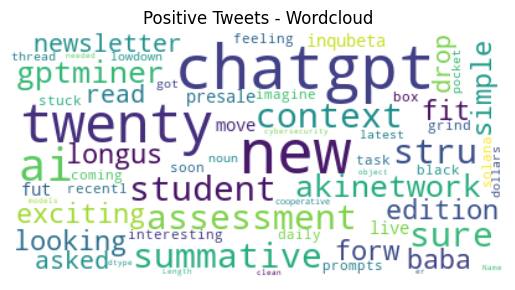

In [ ]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
 
positive_tweets = df_twts['clean'][df_twts["sentiment"] == 'positive']
positive_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(positive_tweets))
plt.figure()
plt.title("Positive Tweets - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

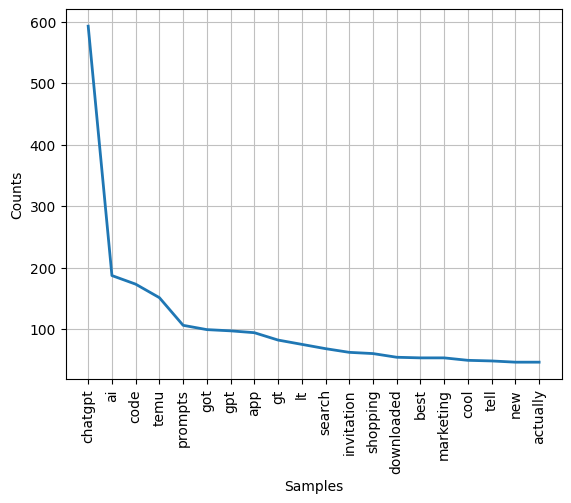

In [ ]:
tweets = [word for tweet in df_twts['words'][df_twts["sentiment"] == 'positive'] for word in tweet]
fqdist = FreqDist(tweets)
fqdist.plot(20,cumulative=False)
plt.show()

In [ ]:
most_common_word = fqdist.most_common(20)
pd.DataFrame(most_common_word, columns=['Word', 'freq']).to_csv("top_pos_words_tweets.csv", index=False)

> Based on the adjectives that appear in the word cloud and the frequency distribution of positive tweets, it is known that ChatGPT is a cool, best, and new AI

### Negative Sentiment

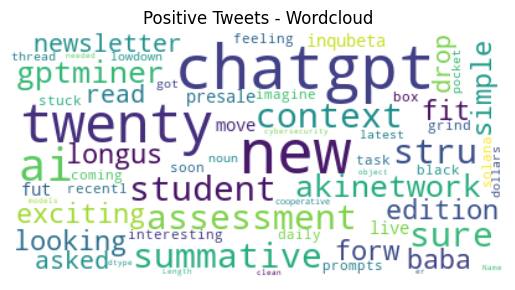

In [ ]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
 
negative_tweets = df_twts['clean'][df_twts["sentiment"] == 'negative']
negative_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(negative_tweets))
plt.figure()
plt.title("Positive Tweets - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

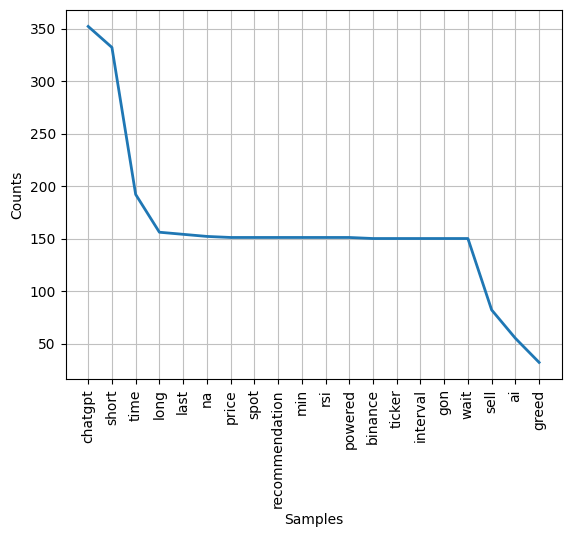

In [ ]:
tweets = [word for tweet in df_twts['words'][df_twts["sentiment"] == 'negative'] for word in tweet]
fqdist = FreqDist(tweets)
fqdist.plot(20,cumulative=False)
plt.show()

In [ ]:
most_common_word = fqdist.most_common(20)
pd.DataFrame(most_common_word, columns=['Word', 'freq']).to_csv("top_neg_words_tweets.csv", index=False)

> Based on the adjectives that appear in the word cloud and the frequency distribution of negative tweets, it is known that ChatGPT is a long, short, greed. The tweet is mostly related to time.

### Neutral Sentiment

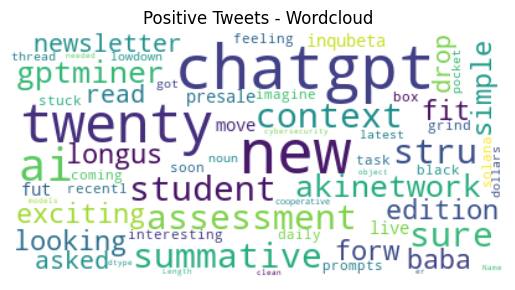

In [ ]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
 
neutral_tweets = df_twts['clean'][df_twts["sentiment"] == 'neutral']
neutral_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(neutral_tweets))
plt.figure()
plt.title("Positive Tweets - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

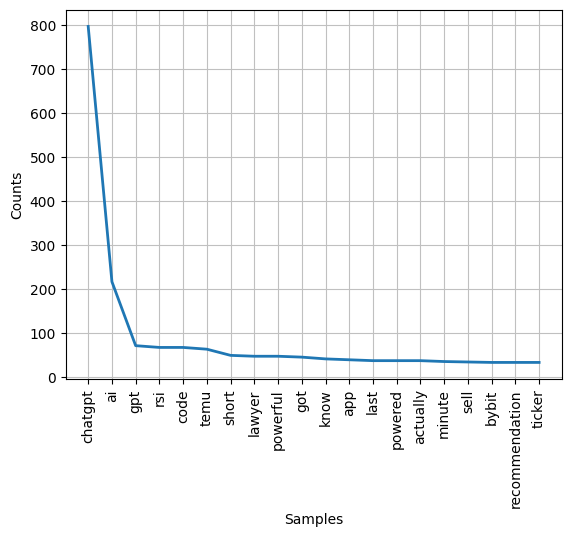

In [ ]:
tweets = [word for tweet in df_twts['words'][df_twts["sentiment"] == 'neutral'] for word in tweet]
fqdist = FreqDist(tweets)
fqdist.plot(20,cumulative=False)
plt.show()

In [ ]:
most_common_word = fqdist.most_common(20)
pd.DataFrame(most_common_word, columns=['Word', 'freq']).to_csv("top_neu_words_tweets.csv", index=False)

> Based on the adjectives that appear in the word cloud and the frequency distribution of neutal tweets, it is mostly related to how powerful chatgpt is.

# Saving Data

## **Dashboard**

In [ ]:
df_saved = df_twts.drop(['clean', 'stem', 'words'], axis=1)
df_saved.to_csv('chatgpt_sentiment.csv', index=False)
df_saved.head()

,username,text,created_at,rt_count,like_count,impression_count,url,sentiment
0,bethelome,#Breaking: How Does ChatGPT Work? What Is an A...,2023-05-28 23:59:58+00:00,0,0,24,https://twitter.com/twitter/status/16629720109...,negative
1,timbocop,"@CCguerilla In a summative assessment context,...",2023-05-28 23:59:43+00:00,0,1,77,https://twitter.com/twitter/status/16629719471...,positive
2,SystematicAlpha,$MSFT will eat the world and be the most valua...,2023-05-28 23:59:42+00:00,0,0,27,https://twitter.com/twitter/status/16629719413...,neutral
3,xPaterax,Using ChatGPT?\n\nHave you met BetterDAN yet? ...,2023-05-28 23:59:30+00:00,0,0,41,https://twitter.com/twitter/status/16629718935...,neutral
4,alyceralphlplq,@MartianCorazon #AkiNetwork #GPTMiner Exciting...,2023-05-28 23:59:24+00:00,0,0,2,https://twitter.com/twitter/status/16629718696...,positive


Link Tableau Dashboards: https://public.tableau.com/app/profile/fitri.aliyah/viz/ChatGPTSentimentAnalysisDashboard/Dashboard

## **Insights from Dashboard**

- Neutral sentiment surpass other sentiments in quantity
- Negative sentiment represent a relatively small portion, accounting for 20,28% of the total data.
- But, 3 of top 5 popular tweets are characterized as negative sentiments.
- Negative opinions are more prevalent from 10 PM to 11. 30 PM

# **Recommendations**

- Engage with positive sentiments
- Investigate the underlying reasons behind negative sentiments
- Improve customer support during peak negative sentiments hour
- Continuous Sentiment Analysis and Monitoring

Things that can be done to potentially improve analysis:
- Try to detect spam since many words in the frequency distribution are related to cryptocurrency, which may not be relevant to the sentiment of ChatGPT, implementing spam detection techniques can help filter out irrelevant or misleading data from the analysis.
- Increasing the amount of data can provide a more comprehensive and representative sample.

Reference: 
*   https://www.kaggle.com/code/shailaja4247/sentiment-analysis-of-tweets-wordclouds-textblob
*   Materi Bootcamp Sanbercode : Python Data Science - Machine Learning & Public Opinion Analysis